In [98]:
# MCMC on cifar10 for i.i.d. data samples
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.stats import invgamma
from scipy import stats
from itertools import permutations
import matplotlib.ticker as ticker

In [ ]:
N=100
P=200
X=tf.random.normal([N,P], 0, 1, tf.float32)
X.shape

In [29]:
# Generate the vector Y function
def Generate(N,P,X,h,tau,nu_0,lambda_0):
  gamma=bernoulli.rvs(1, size=P)
  sigmasq=(1/2)*nu_0*lambda_0*invgamma.rvs((1/2)*nu_0,size=1)
  count=0
  for j in range(len(gamma)):
    if (gamma[j]==1):
      count=count+1 # Estimate |gamma|
  mean=np.zeros(count)
  tilX=np.zeros((N,count))
  k=0
  for j in range(P):
    if (gamma[j]==1):
      tilX[:,k]=X[:,j]
      k=k+1
  cov=sigmasq*tau**(-1)*np.identity(count)
  beta=multivariate_normal.rvs(mean,cov)
  beta=beta.transpose()
  mean=np.dot(tilX,beta)
  cov=sigmasq*np.identity(N)  
  Y=multivariate_normal.rvs(mean,cov)
  return Y

In [31]:
# Estimate PIP function, X is the N xP designed matrix
def PIP_estimate(A,nu,N,P,gamma,h,X,Y,tau,nu_0,lambda_0,i):
  # define two vector tgamma_1 and tgamma_0
  tgamma_1=gamma
  tgamma_0=gamma
  tgamma_1[i]=1
  tgamma_0[i]=0
  count=0 #counting the number of non-zero elements in vector tgamma_0
  for j in range(len(tgamma_0)):
    if (tgamma_0[j]==1):
      count=count+1
  Xtilgamma_0=np.zeros((N, count))
  a_i=np.zeros((count,1)) #vector a_i
  nugamma_0=np.zeros((count,1))
  k=0
  for j in range(len(tgamma_0)):
    if (tgamma_0[j]==1):
      a_i[k]=A[j,i]
      nugamma_0[k]=nu[j]
      Xtilgamma_0[:,k]=X[:,j]
      k=k+1
  F=np.linalg.inv(np.dot(Xtilgamma_0.transpose(),Xtilgamma_0)+tau*np.identity(count))
  d_i=(A[i,i]+ tau-np.dot(np.dot(a_i.transpose(),F),a_i))**(-1)
  #Estimate S(tgamma_0)
  S_0=np.dot(Y.transpose(),Y)-Y.transpose().dot(Xtilgamma_0).dot(F)\
      .dot(Xtilgamma_0.transpose()).dot(Y)+nu_0*lambda_0
  S_1=S_0-d_i*(nugamma_0.transpose().dot(F).dot(a_i)-nu[i])**2
  etatemp= np.sqrt(tau*d_i*(S_0/S_1)**(N+nu_0))
  eta_1= (h/(1-h))*etatemp
  eta_0=(eta_1)**(-1)
  condPIP1_i=eta_1/(1+eta_1)  #P(gamma_i=1|gamma_{-i},Y)
  if (gamma[i]==1):
    condPIP_i=eta_1*(1+eta_1)**(-1)
  else:
    condPIP_i=eta_0*(1+eta_0)**(-1) 
  #print(gamma)  
  return condPIP1_i, condPIP_i #P(gamma_i=1|gamma_{-i},Y) and #P(gamma_i|gamma_{-i},Y)

In [32]:
def combinations(iterable,r):
  pool=tuple(iterable)
  n=len(pool)
  for indices in permutations(range(n),r):
    if sorted(indices)==list(indices):
       yield tuple(pool[i] for i in indices)

In [33]:
# This function genates a random set over all (P choose S-1) sets of size S which contain i_0
def random_set_gen(P,S,i_0):
  iterable=set(np.arange(P))-set([i_0])
  output=combinations(iterable,S-1)
  outlist=list(output)
  l=len(outlist)
  nu=np.random.randint(0,l,size=1,dtype=int)
  S_setm=outlist[int(nu)] # S setminus i_0
  S_setm=set(S_setm).union(set([i_0]))
  S_setm=list(S_setm)
  return S_setm

In [34]:
# Fixed-Complexity MCMC algorithm
def MCMC_fixed(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,T,S,i):
  gamma=np.ones((P)) #bernoulli.rvs(h, size=P)
  gammaele=np.zeros((T))
  tilrho=np.ones((T))
  Indvec=np.zeros((T))
  conPIPout=np.zeros((T))
  i_t=np.random.randint(P, size=1)
  i_t=int(i_t)
  S_t=np.arange(P) #random_set_gen(P,S,i_t)
  for t in range(T):
      theta=0 #Estimate theta(gamma)
      condPIP1=np.zeros((P))
      condPIP=np.zeros((P)) 
      gammaele[t]=gamma[i] 
      for j in S_t:
         #print(gamma)
         condPIP1[j],condPIP[j]=PIP_estimate(A,nu,N,P,gamma,h,X,Y,tau,nu_0,lambda_0,j) 
         eta=condPIP1[j]+ eps/P
         theta=theta+ (1/2)*eta/condPIP[j]
         #print(gamma)   
      tilrho[t]=theta**(-1) # Compute the unnormalized weights   
      if i in S_t:
         Indvec[t]=1   
         conPIPout[t]=condPIP1[i]  
      conddis=np.zeros((P))
      # Estimate conditional distribution f(j|gamma)
      for j in range(P):
         if j in S_t:    
            eta=condPIP1[j]+ eps/P
            conddis[j]=theta**(-1)*(1/2)*eta/condPIP[j]
      xk=np.arange(P)
      custm=stats.rv_discrete(name='custm', values=(xk, conddis))
      # Sample i_t ~ f(.|gamma)
      i_t=custm.rvs(size=1)
      temp=gamma[i_t]
      #print(temp)  
      gamma[i_t]=1-temp
      #print(gamma[i_t]) 
    #Sample a a new set S_t
      i_t=int(i_t)
      S_t=np.arange(P) #random_set_gen(P,S,i_t)   
  return gammaele,tilrho,Indvec,conPIPout

In [35]:
def estimator_fixed(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i): # Subset wTGS estimator 
  gammaele,tilrho,Indvec,conPIPout=MCMC_fixed(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i)  
  E_0=np.zeros((Tmax))
  for T in range(Tmax):
    temp=0   
    for t in range(T):
      temp=temp+tilrho[t]
    sumrho=temp
    tempE=0 
    for t in range(T):
      rho=tilrho[t]/sumrho  #rho^{(t)}
      #print(rho)
 #Define the Rao-Blackwellized estimator
      #tempE=tempE+ rho*(conPIPout[t]*Indvec[t]+(1-Indvec[t])*gammaele[t])
      tempE=tempE+ rho*gammaele[t] #Naive estimator
    E_0[T]=tempE
  return E_0

In [36]:
def Var_Est_fixed(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i):
  varE0m=np.zeros((Tmax))
  gamma_i,tilrho,Indvec,conPIPout=MCMC_fixed(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i)
  E_0m=np.zeros((Tmax))
  for T in range(Tmax):
    temp=0   
    for t in range(T):
        temp=temp+tilrho[t]
    sumrho=temp
    tempE=0 
    for t in range(T):
        rho=tilrho[t]/sumrho  #rho^{(t)}
#Define the Rao-Blackwellized estimator
        tempE=tempE+ rho*(conPIPout[t]*Indvec[t]+(1-Indvec[t])*gamma_i[t])
    E_0m[T]=tempE 
# Estimate the variance of the estimator
  mean_0=tempE 
  for T in range(Tmax):
    varE0m[T]=(E_0m[T]-mean_0)**2  
  return varE0m    

In [37]:

# Variable-Complexity MCMC algorithm
def MCMC(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,T,S,i):  
  gamma_tx=bernoulli.rvs(h, size=P) 
  tilrho=np.ones((T))
  Qmat=np.zeros((T))
  conPIPout=np.zeros((T))
  Q=1
  for t in range(T):  
    if (Q==1):  
      theta=0 #Estimate theta(gamma)
      condPIP1=np.zeros((P))
      condPIP=np.zeros((P))
      for j in range(P):
          condPIP1[j],condPIP[j]=PIP_estimate(A,nu,N,P,gamma_tx,h,X,Y,tau,nu_0,lambda_0,j)
          eta=condPIP1[j]+ eps/P
          theta=theta+ (1/2)*eta/condPIP[j]
      conPIPout[t]=condPIP1[i]
      tilrho[t]=theta**(-1) # Compute the unnormalized weights 
      conddis=np.zeros((P))
      # Estimate conditional distribution f(j|gamma)
      for j in range(P):
        eta=condPIP1[j]+ eps/P
        conddis[j]=theta**(-1)*(1/2)*eta/condPIP[j]
      xk=np.arange(P)
      custm=stats.rv_discrete(name='custm', values=(xk, conddis))
      # Sample i_t ~ f(.|gamma)
      i_t=custm.rvs(size=1)  
      temp=gamma_tx[i_t]
      gamma_tx[i_t]=1-temp
    Qmat[t]=Q
    #Sample a Bernoulli random variable
    Q=bernoulli.rvs(S/P, size=1)
  return tilrho,Qmat,conPIPout

In [38]:
def estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i):
 tilrho,Qmat,conPIPout=MCMC(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i)
 E_0=np.zeros((Tmax))
 for T in range(Tmax):
   temp=0   
   for t in range(T):
     temp=temp+tilrho[t]*Qmat[t]
   sumrho=temp
   tempE=0 
   for t in range(T):
     rho=tilrho[t]*Qmat[t]/sumrho  #rho^{(t)}
 #Define the Rao-Blackwellized estimator
     tempE=tempE+ rho*conPIPout[t]
   E_0[T]=tempE
 return E_0

In [39]:
def Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i):
  varE0m=np.zeros((Tmax))
  tilrho,Qmat,conPIPout=MCMC(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P,i)
  E_0m=np.zeros((Tmax))
  for T in range(Tmax):
    temp=0   
    for t in range(T):
       temp=temp+tilrho[t]*Qmat[t]
    sumrho=temp
    tempE=0 
    for t in range(T):
       rho=tilrho[t]*Qmat[t]/sumrho  #rho^{(t)}
#Define the Rao-Blackwellized estimator
       tempE=tempE+ rho*conPIPout[t]
    E_0m[T]=tempE
  mean_0=tempE 
  tilrho,Qmat,conPIPout=MCMC(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,i)
  E_0m=np.zeros((Tmax))
  for T in range(Tmax):
    temp=0   
    for t in range(T):
       temp=temp+tilrho[t]*Qmat[t]
    sumrho=temp
    tempE=0 
    for t in range(T):
       rho=tilrho[t]*Qmat[t]/sumrho  #rho^{(t)}
#Define the Rao-Blackwellized estimator
       tempE=tempE+ rho*conPIPout[t]
    E_0m[T]=tempE 
# Estimate the variance of the estimator
  for T in range(Tmax):
    varE0m[T]=(E_0m[T]-mean_0)**2  
  return varE0m    

In [40]:
N=X.shape[0]
P=X.shape[1]
Xtran=tf.transpose(X)
A=np.dot(Xtran,X)
nu_0=2
lambda_0=2
h=0.5
tau=1
eps=0.1
Y=Generate(N,P,X,h,tau,nu_0,lambda_0)
nu=np.dot(Xtran,Y)

In [128]:
Tmax=20000
S=2
varE0mfixed=Var_Est_fixed(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,0)
varE0m=Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,S,0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


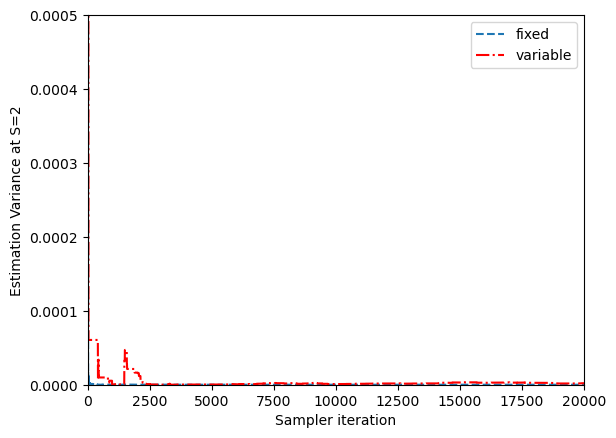

In [132]:
Tmax=20000
Trange=np.arange(Tmax)
# variance plots
plt.plot(Trange[1:Tmax],varE0mfixed[1:Tmax],'--',Trange[1:Tmax],varE0m[1:Tmax],'r-.')
plt.ylabel('Estimation Variance at S=2')
plt.xlabel('Sampler iteration')
#plt.grid(color='k', linestyle='--', linewidth=0.01)
plt.axis([0, Tmax, 0, 5*10**(-4)])
plt.legend(['fixed','variable'])
plt.savefig('plot5b.eps')
plt.savefig('plot5b.png')
plt.show()

In [41]:
Tmax=20000

E_0=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/4,0)
E_1=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/4,1)
E_f=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/4,P-1)

E_0m=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P,0)
E_0v=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/20,0)
E_0n=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/100,0)

E_1m=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P,1)
E_1v=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/20,1)
E_1n=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/100,1)

E_fm=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P,P-1)
E_fv=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/20,P-1)
E_fn=estimator(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/100,P-1)


In [46]:

varE0m=Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/4,0)
varE0u=Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/20,0)
varE0n=Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/100,0)


In [112]:
varE1m=Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/4,1)
varE1u=Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/20,1)
varE1n=Var_Est(A,nu,N,P,h,X,Y,tau,nu_0,lambda_0,eps,Tmax,P/100,1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


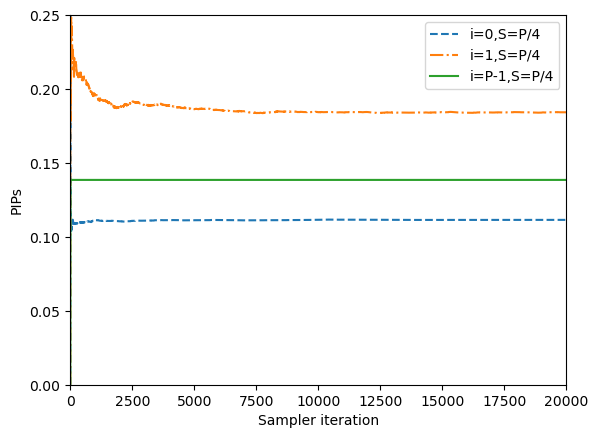

In [111]:
Tmax=20000
Trange=np.arange(Tmax)
plt.plot(Trange,E_0,'--',Trange,E_1,'-.',Trange,E_f)
plt.ylabel('PIPs')
plt.xlabel('Sampler iteration')
#plt.grid(color='k', linestyle='--', linewidth=0.01)
plt.axis([0, Tmax, 0, 0.25])
plt.legend(['i=0,S=P/4', 'i=1,S=P/4','i=P-1,S=P/4'])
plt.savefig('plot1a.eps')
plt.savefig('plot1a.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


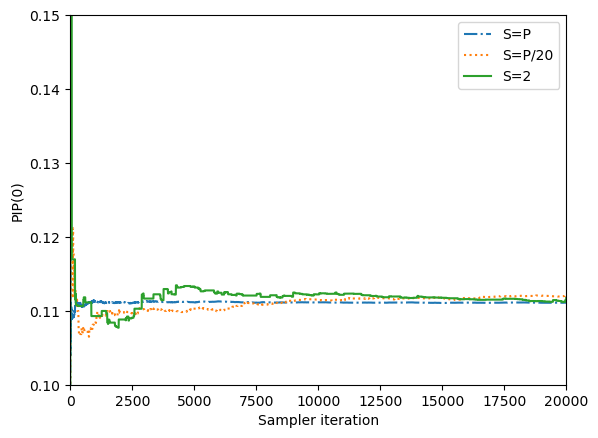

In [107]:
plt.plot(Trange,E_0m,'-.',Trange,E_0v,':',Trange,E_0n,'-')
plt.ylabel('PIP(0)')
plt.xlabel('Sampler iteration')
#plt.grid(color='k', linestyle='--', linewidth=0.01)
plt.axis([0, Tmax, 0.10, 0.15])
plt.legend(['S=P','S=P/20','S=2'])
plt.savefig('plot2a.eps')
plt.savefig('plot2a.png')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


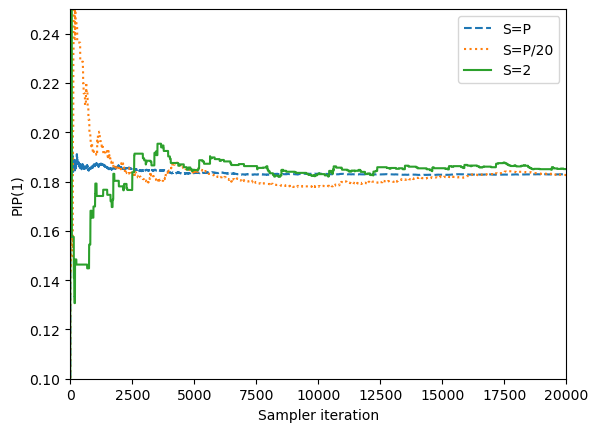

In [108]:
plt.plot(Trange,E_1m,'--',Trange,E_1v,':',Trange,E_1n,'-')
plt.ylabel('PIP(1)')
plt.xlabel('Sampler iteration')
#plt.grid(color='k', linestyle='--', linewidth=0.01)
plt.axis([0, Tmax, 0.10, 0.25])
plt.legend(['S=P','S=P/20','S=2'])
plt.savefig('plot3a.eps')
plt.savefig('plot3a.png')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


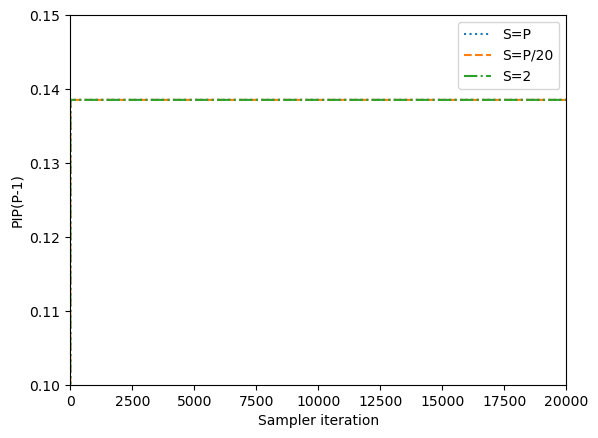

In [109]:
plt.plot(Trange,E_fm,':',Trange,E_fv,'--',Trange,E_fn,'-.')
plt.ylabel('PIP(P-1)')
plt.xlabel('Sampler iteration')
#plt.grid(color='k', linestyle='--', linewidth=0.01)
plt.axis([0, Tmax, 0.10, 0.15])
plt.legend(['S=P','S=P/20', 'S=2'])
plt.savefig('plot4a.eps')
plt.savefig('plot4a.png')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


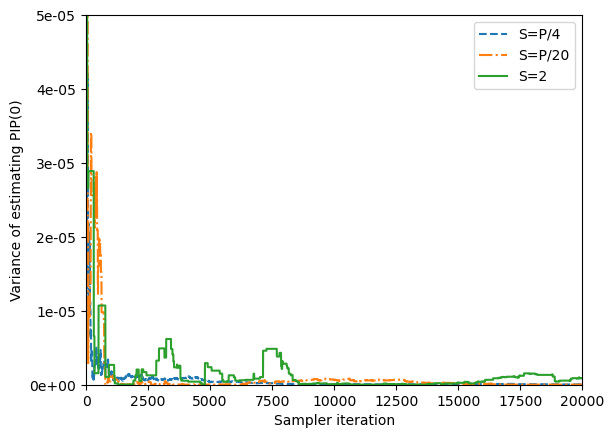

In [127]:
# variance plots
plt.plot(Trange,varE0m,'--',Trange,varE0u,'-.',Trange,varE0n)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
plt.ylabel('Variance of estimating PIP(0)')
plt.xlabel('Sampler iteration')
#plt.grid(color='k', linestyle='--', linewidth=0.01)
plt.axis([0, 20000, 0, 5e-05])
plt.legend(['S=P/4', 'S=P/20','S=2'])
plt.savefig('plot5a.eps')
plt.savefig('plot5a.png')
#plt.grid()
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


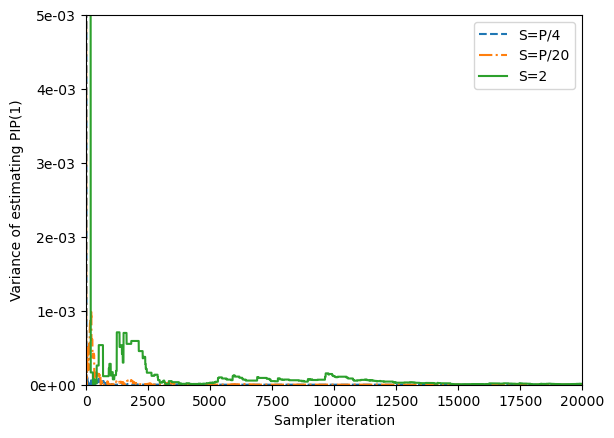

In [126]:
# variance plots
plt.plot(Trange,varE1m,'--',Trange,varE1u,'-.',Trange,varE1n)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
plt.ylabel('Variance of estimating PIP(1)')
plt.xlabel('Sampler iteration')
#plt.grid(color='k', linestyle='--', linewidth=0.01)
plt.axis([0, 20000, 0, 5e-03])
plt.legend(['S=P/4', 'S=P/20','S=2'])
plt.savefig('plot6a.eps')
plt.savefig('plot6a.png')
#plt.grid()
plt.show()